In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import plotly.express as px
import plotly.graph_objs as go

In [2]:
nltk.download('omw')
nltk.download('omw-1.4')

[nltk_data] Downloading package omw to C:\Users\Harsh
[nltk_data]     Clean\AppData\Roaming\nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Harsh
[nltk_data]     Clean\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
data = pd.read_csv('../../Warehouse/Reviews/app_reviews_merged.csv')

In [4]:
# Preprocessing the 'content' column
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Harsh
[nltk_data]     Clean\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Harsh
[nltk_data]     Clean\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  # Remove punctuation and convert to lowercase
    words = nltk.word_tokenize(text)  # Tokenize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Remove stopwords and lemmatize
    return ' '.join(words)

In [6]:
data['processed_content'] = data['content'].apply(preprocess_text)

In [7]:
# Extracting topics using LDA
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
X = vectorizer.fit_transform(data['processed_content'])

lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X)

data['topic'] = np.argmax(lda.transform(X), axis=1)

In [8]:
# Grouping by app version and analyzing the distribution of review scores and topics
version_analysis = data.groupby('reviewCreatedVersion').agg({'score': ['mean', 'count'], 'topic': lambda x: x.mode()[0]})
version_analysis.columns = ['mean_score', 'review_count', 'most_common_topic']

In [9]:
fig = px.bar(version_analysis, x=version_analysis.index, y='mean_score', 
             labels={'x': 'App Version', 'y': 'Average Score'}, 
             title='Average Review Score by App Version')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [10]:
fig = px.bar(version_analysis, x=version_analysis.index, y='review_count', 
             labels={'x': 'App Version', 'y': 'Review Count'}, 
             title='Number of Reviews by App Version')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [11]:
fig = px.histogram(version_analysis, x='most_common_topic', color='most_common_topic',
                   labels={'most_common_topic': 'Most Common Topic', 'count': 'Frequency'},
                   title='Most Common Topic by App Version')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [12]:
# Save the version_analysis DataFrame to a CSV file
version_analysis.to_csv('version_analysis.csv')

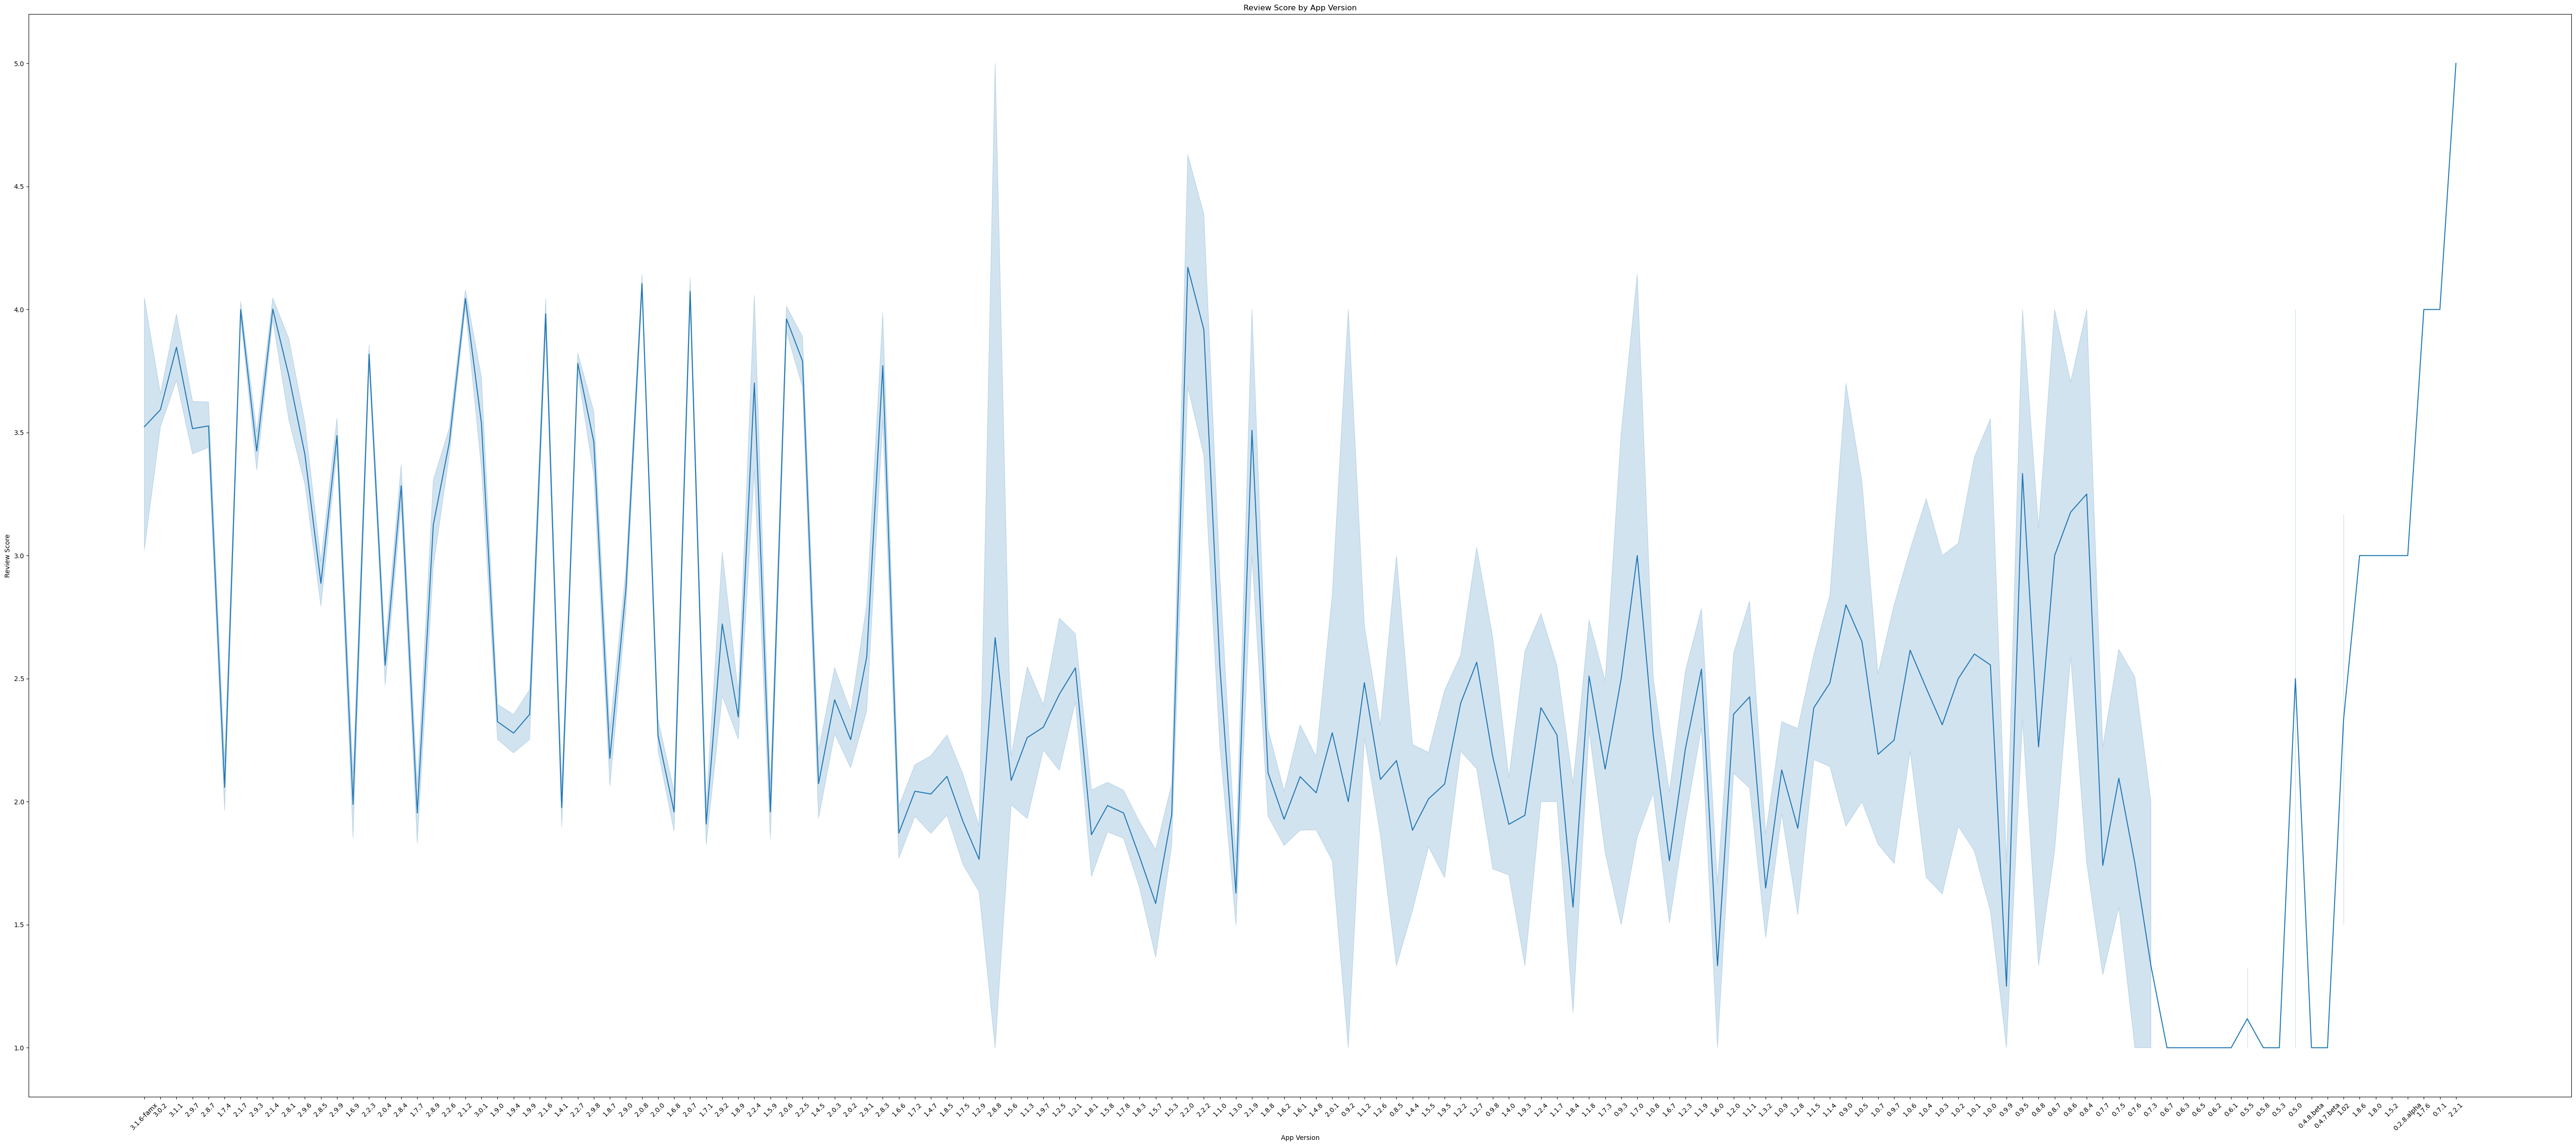

In [29]:
# make a simple plot of the rating of the app over time and over each version
plt.figure(figsize=(70, 30))
sns.lineplot(x=data['reviewCreatedVersion'], y=data['score'])
plt.xticks(rotation=45)
plt.xlabel('App Version')
plt.ylabel('Review Score')
plt.title('Review Score by App Version')
plt.savefig('review_score_by_app_version.png')
plt.show()

In [30]:
# Create line plot
fig = px.line(data, x='reviewCreatedVersion', y='score', title='Review Score by App Version', width=1400, height=600)

# Add trendline
fig.add_trace(go.Scatter(x=data['reviewCreatedVersion'], y=data['score'].rolling(10).mean(),
                    mode='lines',
                    line=go.scatter.Line(color='red', width=3),
                    name='Trendline'))

# Add markers
fig.update_traces(mode='markers+lines', marker=dict(size=8))

# Add shaded regions
fig.add_shape(type='rect',
                xref='x',
                yref='paper',
                x0='3.5',
                y0=0,
                x1='4.5',
                y1=1,
                fillcolor='LightSalmon',
                opacity=0.3,
                layer='below',
                line_width=0)

# Customize axes
fig.update_xaxes(title_text='App Version', tickangle=45)
fig.update_yaxes(title_text='Review Score')

# Show plot
fig.show()